In [1]:
try:
    import implicit
    import lightfm
except ImportError:
    !pip install -qU implicit
    !pip install lightfm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=831124 sha256=494fdf1f889145ef548e89665e6805a122c285fedab8833fafea0ca411b2b46f
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, ndcg_score, accuracy_score
from sklearn.decomposition import TruncatedSVD, PCA, NMF
from sklearn.neighbors import NearestNeighbors
from lightfm import LightFM
from lightfm.data import Dataset
from scipy.sparse import csr_matrix, coo_matrix
from implicit.als import AlternatingLeastSquares
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# ============================ Загрузка и подготовка данных ============================
df = pd.read_csv("calls.csv", sep=";")
df = df[~df['owner'].str.contains('cookies', na=False)]
df = df.sort_values('start_time')

owners = df['owner'].unique()
mids = df['mid'].unique()

train_size = int(len(df) * 0.7)
df_train = df[:train_size]
df_test = df[train_size:]

def build_matrix(df, owners, mids, normalize=False):
    pivot = df.pivot_table(index='owner', columns='mid', values='id', aggfunc='count').fillna(0)
    pivot = pivot.reindex(index=owners, columns=mids, fill_value=0)

    mat = pivot.values

    if normalize:
        row_sums = mat.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1
        mat = mat / row_sums
    return mat

X_train = build_matrix(df_train, owners, mids, normalize=True)
X_test = build_matrix(df_test, owners, mids, normalize=True)

# ============================ Популярность ============================
def get_popular_services(df, mids):
    counts = df['mid'].value_counts().reindex(mids, fill_value=0)
    counts_max = np.max(counts.values)
    return np.argsort(counts.values/counts_max)[::-1]

popular_services = get_popular_services(df_train, mids)

# ============================ Методы ============================
class KNNRecommender:
    def __init__(self, n_neighbors=4):
        self.model = NearestNeighbors(n_neighbors=n_neighbors+1, metric='cosine')

    def fit(self, X):
        self.X = X
        self.model.fit(X)
        self.indices = self.model.kneighbors(X, return_distance=False)

    def predict(self):
        preds = np.zeros_like(self.X)
        for i, neighbors in enumerate(self.indices):
            neighbors = neighbors[1:]
            preds[i] = self.X[neighbors].mean(axis=0)
        return preds

class SVDRecommender:
    def __init__(self, model):
        self.model = model

    def fit(self, X):
        self.X = X
        self.embeddings = self.model.fit_transform(X)

    def predict(self):
        return self.model.inverse_transform(self.embeddings)

# ============================ LightFMTuner ============================
class LightFMTuner:
    def __init__(self, param_grid):
        self.param_grid = param_grid

    def tune(self, df_train, owners, mids, X_train, used_train, actual_test, mids_list, popular_services, k):
        results = []
        for loss in self.param_grid['loss']:
            for epochs in self.param_grid['epochs']:
                for no_components in self.param_grid['no_components']:
                    dataset = Dataset()
                    dataset.fit(owners, mids)
                    interactions, _ = dataset.build_interactions([(row['owner'], row['mid']) for _, row in df_train.iterrows()])
                    model = LightFM(loss=loss, no_components=no_components)
                    model.fit(interactions, epochs=epochs, num_threads=4)

                    uid_map = dataset.mapping()[0]
                    iid_map = dataset.mapping()[2]
                    num_items = len(iid_map)
                    preds = []
                    for user in owners:
                        uid = uid_map[user]
                        scores = model.predict(uid, np.arange(num_items))
                        preds.append(scores)
                    preds = np.array(preds)
                    recs = get_recommendations(preds, used_train, popular_services, k)
                    metrics = evaluate(recs, actual_test, mids_list, preds, k)
                    results.append({
                        'loss': loss,
                        'epochs': epochs,
                        'no_components': no_components,
                        **metrics
                    })
                    print(f"loss={loss}, epochs={epochs}, no_components={no_components} -> {metrics}")
        return pd.DataFrame(results)

class KNNLightFMTuner:
    def __init__(self, param_grid):
        self.param_grid = param_grid

    def tune(self, df_train, owners, mids, X_train, used_train, actual_test, mids_list, popular_services, k):
        results = []
        knn_model = KNNRecommender(n_neighbors=4)
        knn_model.fit(X_train)
        knn_preds = knn_model.predict()

        hybrid_matrix = X_train + 1 * knn_preds

        for loss in self.param_grid['loss']:
            for epochs in self.param_grid['epochs']:
                for no_components in self.param_grid['no_components']:
                    dataset = Dataset()
                    dataset.fit(owners, mids)
                    interactions, _ = dataset.build_interactions([(owners[i], mids[j]) for i, j in zip(*hybrid_matrix.nonzero())])

                    model = LightFM(loss=loss, no_components=no_components)
                    model.fit(interactions, epochs=epochs, num_threads=4)

                    uid_map = dataset.mapping()[0]
                    iid_map = dataset.mapping()[2]
                    num_items = len(iid_map)
                    preds = []
                    for user in owners:
                        uid = uid_map[user]
                        scores = model.predict(uid, np.arange(num_items))
                        preds.append(scores)
                    preds = np.array(preds)
                    recs = get_recommendations(preds, used_train, popular_services, k)
                    metrics = evaluate(recs, actual_test, mids_list, preds, k)
                    results.append({
                        'loss': loss,
                        'epochs': epochs,
                        'no_components': no_components,
                        **metrics
                    })
                    print(f"loss={loss}, epochs={epochs}, no_components={no_components} -> {metrics}")
        return pd.DataFrame(results)

class LightFMRecommender:
    def __init__(self, loss, no_components, epochs):
        self.loss = loss
        self.no_components = no_components
        self.epochs = epochs

    def fit(self, df, owners, mids):
        dataset = Dataset()
        dataset.fit(owners, mids)
        interactions, _ = dataset.build_interactions([(row['owner'], row['mid']) for _, row in df.iterrows()])
        self.model = LightFM(loss=self.loss, no_components=self.no_components)
        self.model.fit(interactions, epochs=self.epochs, num_threads=4)
        self.dataset = dataset
        self.owners = owners
        self.mids = mids
        self.interactions = interactions

    def predict(self):
        uid_map = self.dataset.mapping()[0]
        iid_map = self.dataset.mapping()[2]
        inv_iid_map = {v: k for k, v in iid_map.items()}
        num_items = len(iid_map)
        preds = []
        for user in self.owners:
            uid = uid_map[user]
            scores = self.model.predict(uid, np.arange(num_items))
            preds.append(scores)
        return np.array(preds)

class HybridKNNLightFMRecommender:
    def __init__(self, loss='warp', no_components=20, epochs=20, knn_neighbors=4, alpha=1):
        self.loss = loss
        self.no_components = no_components
        self.epochs = epochs
        self.knn_neighbors = knn_neighbors
        self.alpha = alpha

    def fit(self, df_train, owners, mids, X_train):
        knn_model = KNNRecommender(n_neighbors=self.knn_neighbors)
        knn_model.fit(X_train)
        knn_preds = knn_model.predict()

        hybrid_matrix = X_train + self.alpha * knn_preds

        dataset = Dataset()
        dataset.fit(owners, mids)
        interactions, _ = dataset.build_interactions([(owners[i], mids[j]) for i, j in zip(*hybrid_matrix.nonzero())])

        self.model = LightFM(loss=self.loss, no_components=self.no_components)
        self.model.fit(interactions, epochs=self.epochs, num_threads=4)

        self.dataset = dataset
        self.owners = owners
        self.mids = mids

    def predict(self):
        uid_map = self.dataset.mapping()[0]
        iid_map = self.dataset.mapping()[2]
        num_items = len(iid_map)
        preds = []
        for user in self.owners:
            uid = uid_map[user]
            scores = self.model.predict(uid, np.arange(num_items))
            preds.append(scores)
        return np.array(preds)

def best_lightFM(df_train, owners, mids, X_train, used_train, actual_test,  popular_services, k, loss):
    # Тюнинг LightFM
    lf_param_grid = {
        'loss': [loss],
        'epochs': [10, 20],
        'no_components': [10, 20, 40]
    }

    lf_tuner = LightFMTuner(param_grid=lf_param_grid)
    lf_results = lf_tuner.tune(df_train, owners, mids, X_train, used_train, actual_test, mids, popular_services, k)

    best_lf_row = lf_results.sort_values(by='precision', ascending=False).iloc[0]
    return LightFMRecommender(
        loss=best_lf_row['loss'],
        no_components=int(best_lf_row['no_components']),
        epochs=int(best_lf_row['epochs'])
    )

def best_knn_lightFM(df_train, owners, mids, X_train, used_train, actual_test,  popular_services, k, loss):
    # Тюнинг LightFM
    lf_param_grid = {
        'loss': [loss],
        'epochs': [10, 20],
        'no_components': [10, 20, 40]
    }

    lf_tuner = KNNLightFMTuner(param_grid=lf_param_grid)
    lf_results = lf_tuner.tune(df_train, owners, mids, X_train, used_train, actual_test, mids, popular_services, k)

    best_lf_row = lf_results.sort_values(by='precision', ascending=False).iloc[0]
    return HybridKNNLightFMRecommender(
        loss=best_lf_row['loss'],
        no_components=int(best_lf_row['no_components']),
        epochs=int(best_lf_row['epochs']),
        alpha=1.0
    )
# ============================ ALS с тюннингом ============================
class ALSRecommender:
    def __init__(self, factors=20, regularization=0.1, iterations=10):
        self.factors = factors
        self.regularization = regularization
        self.iterations = iterations

    def fit(self, X):
        self.model = AlternatingLeastSquares(
            factors=self.factors,
            regularization=self.regularization,
            iterations=self.iterations
        )
        self.X = csr_matrix(X * 20)
        self.model.fit(self.X)

    def predict(self):
        return self.model.user_factors @ self.model.item_factors.T
def best_als(X_train, X_test, used_train, actual_test, mids, popular_services, k):
    def tune_als(X_train, X_test, used_train, actual_test, mids, popular_services, k, param_grid):
        results = []
        for factors in param_grid['factors']:
            for reg in param_grid['regularization']:
                for iters in param_grid['iterations']:
                    model = AlternatingLeastSquares(factors=factors, regularization=reg, iterations=iters)
                    X = csr_matrix(X_train * 20)
                    model.fit(X)
                    preds = model.user_factors @ model.item_factors.T
                    recs = get_recommendations(preds, used_train, popular_services, k)
                    metrics = evaluate(recs, actual_test, mids, preds, k)
                    results.append({
                        'factors': factors,
                        'regularization': reg,
                        'iterations': iters,
                        **metrics
                    })
                    print(f"factors={factors}, reg={reg}, iters={iters} -> {metrics}")
        return pd.DataFrame(results)

    # Пример запуска тюнинга ALS
    param_grid = {
        'factors': [10, 20, 40],
        'regularization': [0.01, 0.1, 1],
        'iterations': [10, 20]
    }

    als_tuning_results = tune_als(X_train, X_test, used_train, actual_test, mids, popular_services, k=15, param_grid=param_grid)

    # Добавим лучшую ALS-модель в сравнение (по precision, например)
    best_row = als_tuning_results.sort_values(by='precision', ascending=False).iloc[0]
    print("\nBest ALS params:", best_row[['factors', 'regularization', 'iterations']].to_dict())

    best_als = ALSRecommender(
        factors=int(best_row['factors']),
        regularization=float(best_row['regularization']),
        iterations=int(best_row['iterations'])
    )
    return best_als

# ========================================================

class WRMFRecommender:
    def fit(self, X):
        self.model = AlternatingLeastSquares(factors=20, iterations=10)
        self.X = csr_matrix(X * 20)
        self.model.fit(self.X)

    def predict(self):
        return self.model.user_factors @ self.model.item_factors.T

class PopularRecommender:
    def __init__(self, popular_items):
        self.popular_items = popular_items

    def fit(self, X):
        self.X = X
        pass  # No fitting required

    def predict(self):
        return np.tile(self.popular_items, (self.X.shape[0], 1))

class RandomRecommender:
    def fit(self, X):
        self.X = X
        self.num_items = X.shape[1]

    def predict(self):
        return np.random.rand(self.X.shape[0], self.num_items)

# ============================ Оценка ============================
def get_used_services(X):
    return [set(np.where(row > 0)[0]) for row in X]

def get_recommendations(scores, used, popular, k):
    recs = []
    for i, user_scores in enumerate(scores):
        sorted_items = np.argsort(user_scores)[::-1]
        filtered = [item for item in sorted_items if item not in used[i]]
        if len(filtered) < k:
            extra = [item for item in popular if item not in used[i] and item not in filtered]
            filtered += extra
        recs.append(filtered[:k])
    return recs

def evaluate(recs, actual, all_items, scores, k):
    results = {'accuracy': [], 'precision': [], 'recall': [], 'ndcg': []}
    for i in range(len(recs)):
        y_true = [1 if j in actual[i] else 0 for j in range(len(all_items))]
        y_pred = [1 if j in recs[i] else 0 for j in range(len(all_items))]

        rel_true = [1 if j in actual[i] else 0 for j in recs[i]]
        rel_score = [scores[i][j] if j in recs[i] else 0 for j in recs[i]]

        results['accuracy'].append(accuracy_score(y_true, y_pred))
        results['precision'].append(precision_score(y_true, y_pred, zero_division=0))
        results['recall'].append(recall_score(y_true, y_pred, zero_division=0))
        results['ndcg'].append(ndcg_score([rel_true], [rel_score]) if sum(rel_true) > 0 else 0)

    return {m: np.mean(vals) for m, vals in results.items()}

# ============================ Запуск моделей ============================


used_train = get_used_services(X_train)
actual_test = get_used_services(X_test)
k = 10

models = {
    'KNN': KNNRecommender(),
    'PCA': SVDRecommender(PCA(n_components=5)),
    'NMF': SVDRecommender(NMF(n_components=5, init='random', random_state=0)),
    'SVD': SVDRecommender(TruncatedSVD(n_components=5)),'ALS': best_als(X_train, X_test, used_train, actual_test, mids, popular_services, k=15),
    'ALS': best_als(X_train, X_test, used_train, actual_test, mids, popular_services, k=15),
    'LightFM-WARP': best_lightFM(df_train, owners, mids, X_train, used_train, actual_test,  popular_services, k=15, loss='warp'),
    'PHCF-BPR': best_lightFM(df_train, owners, mids, X_train, used_train, actual_test,  popular_services, k=15, loss='bpr'),
    'KNN+LightFM-WARP': best_knn_lightFM(df_train, owners, mids, X_train, used_train, actual_test,  popular_services, k=15, loss='warp'),
    'KNN+PHCF-BPR': best_knn_lightFM(df_train, owners, mids, X_train, used_train, actual_test,  popular_services, k=15, loss='bpr'),
    'WRMF': WRMFRecommender(),
    'Popular': PopularRecommender(popular_services),
    'Random': RandomRecommender()
}

for name, model in models.items():
    print(f"\n=== {name} ===")
    if name == 'LightFM-WARP' or name == 'PHCF-BPR':
        model.fit(df_train, owners, mids)
        preds = model.predict()
    elif name == 'KNN+LightFM-WARP' or name == 'KNN+PHCF-BPR':
        model.fit(df_train, owners, mids, X_train)
        preds = model.predict()
    else:
        model.fit(X_train)
        preds = model.predict()

    recs = get_recommendations(preds, used_train, popular_services, k)
    metrics = evaluate(recs, actual_test, mids, preds, k)
    for m, v in metrics.items():
        print(f"{m.capitalize()}: {v:.4f}")


  0%|          | 0/10 [00:00<?, ?it/s]

factors=10, reg=0.01, iters=10 -> {'accuracy': np.float64(0.8828352287754563), 'precision': np.float64(0.02456140350877193), 'recall': np.float64(0.029943740470056258), 'ndcg': np.float64(0.08566902467546804)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=10, reg=0.01, iters=20 -> {'accuracy': np.float64(0.8844221105527638), 'precision': np.float64(0.03508771929824562), 'recall': np.float64(0.04360259623417518), 'ndcg': np.float64(0.09567695412527528)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=10, reg=0.1, iters=10 -> {'accuracy': np.float64(0.8828352287754563), 'precision': np.float64(0.02456140350877193), 'recall': np.float64(0.04440588651114966), 'ndcg': np.float64(0.07261944278445208)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=10, reg=0.1, iters=20 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.03157894736842106), 'recall': np.float64(0.06069661332819227), 'ndcg': np.float64(0.08437436242617675)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=10, reg=1, iters=10 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.0724246513720198), 'ndcg': np.float64(0.15594188319244243)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=10, reg=1, iters=20 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.0724246513720198), 'ndcg': np.float64(0.13622966002407336)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=20, reg=0.01, iters=10 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.022071495755706282), 'ndcg': np.float64(0.05791275827161433)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=20, reg=0.01, iters=20 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.03039358302516197), 'ndcg': np.float64(0.08327233919823204)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=20, reg=0.1, iters=10 -> {'accuracy': np.float64(0.8828352287754563), 'precision': np.float64(0.02456140350877193), 'recall': np.float64(0.04315275367906947), 'ndcg': np.float64(0.08116825825289585)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=20, reg=0.1, iters=20 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.07824047297731508), 'ndcg': np.float64(0.12720985855439343)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=20, reg=1, iters=10 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06365272154745838), 'ndcg': np.float64(0.13338325329608583)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=20, reg=1, iters=20 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06365272154745838), 'ndcg': np.float64(0.1334735937993672)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=40, reg=0.01, iters=10 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.03483066640961378), 'ndcg': np.float64(0.07521938588037543)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=40, reg=0.01, iters=20 -> {'accuracy': np.float64(0.8844221105527638), 'precision': np.float64(0.03508771929824561), 'recall': np.float64(0.05895347342715764), 'ndcg': np.float64(0.10509692000245552)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=40, reg=0.1, iters=10 -> {'accuracy': np.float64(0.8828352287754563), 'precision': np.float64(0.02456140350877193), 'recall': np.float64(0.04315275367906947), 'ndcg': np.float64(0.07600959098962144)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=40, reg=0.1, iters=20 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.07824047297731508), 'ndcg': np.float64(0.120088618966756)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=40, reg=1, iters=10 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06365272154745838), 'ndcg': np.float64(0.13377751900220408)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=40, reg=1, iters=20 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06365272154745838), 'ndcg': np.float64(0.13338325329608583)}

Best ALS params: {'factors': 10.0, 'regularization': 0.01, 'iterations': 20.0}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=10, reg=0.01, iters=10 -> {'accuracy': np.float64(0.8817773075905846), 'precision': np.float64(0.017543859649122806), 'recall': np.float64(0.024709208919735236), 'ndcg': np.float64(0.06725712347229997)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=10, reg=0.01, iters=20 -> {'accuracy': np.float64(0.8823062681830204), 'precision': np.float64(0.021052631578947368), 'recall': np.float64(0.025159051474840946), 'ndcg': np.float64(0.09362730491474225)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=10, reg=0.1, iters=10 -> {'accuracy': np.float64(0.8828352287754563), 'precision': np.float64(0.02456140350877193), 'recall': np.float64(0.051474840948525155), 'ndcg': np.float64(0.11471266172994578)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=10, reg=0.1, iters=20 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596495), 'recall': np.float64(0.06024677077308656), 'ndcg': np.float64(0.08271991688925145)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=10, reg=1, iters=10 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.0724246513720198), 'ndcg': np.float64(0.15583509084266467)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=10, reg=1, iters=20 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.0724246513720198), 'ndcg': np.float64(0.1364103410306361)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=20, reg=0.01, iters=10 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.023324628587786483), 'ndcg': np.float64(0.09732434308712798)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=20, reg=0.01, iters=20 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.07824047297731508), 'ndcg': np.float64(0.10374851635369188)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=20, reg=0.1, iters=10 -> {'accuracy': np.float64(0.8817773075905846), 'precision': np.float64(0.01754385964912281), 'recall': np.float64(0.016387121650279547), 'ndcg': np.float64(0.04245999188704008)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=20, reg=0.1, iters=20 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.07824047297731508), 'ndcg': np.float64(0.13875462785680595)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=20, reg=1, iters=10 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06365272154745838), 'ndcg': np.float64(0.15298868411467714)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=20, reg=1, iters=20 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06365272154745838), 'ndcg': np.float64(0.13377751900220408)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=40, reg=0.01, iters=10 -> {'accuracy': np.float64(0.8817773075905846), 'precision': np.float64(0.017543859649122806), 'recall': np.float64(0.024709208919735236), 'ndcg': np.float64(0.05979643257655608)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=40, reg=0.01, iters=20 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.05625952994374047), 'ndcg': np.float64(0.140478073577641)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=40, reg=0.1, iters=10 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.04360259623417518), 'ndcg': np.float64(0.08073734259556468)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=40, reg=0.1, iters=20 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.07824047297731508), 'ndcg': np.float64(0.13901620257023914)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=40, reg=1, iters=10 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06365272154745838), 'ndcg': np.float64(0.13367072665242635)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=40, reg=1, iters=20 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06365272154745838), 'ndcg': np.float64(0.13377751900220408)}

Best ALS params: {'factors': 10.0, 'regularization': 1.0, 'iterations': 10.0}
loss=warp, epochs=10, no_components=10 -> {'accuracy': np.float64(0.8865379529225073), 'precision': np.float64(0.04912280701754385), 'recall': np.float64(0.099212775528565), 'ndcg': np.float64(0.19314127173736964)}
loss=warp, epochs=10, no_components=20 -> {'accuracy': np.float64(0.887595874107379), 'precision': np.float64(0.056140350877192984), 'recall': np.float64(0.1225724567829831), 'ndcg': np.float64(0.198313999815145)}
loss=warp, epochs=10, no_components=40 -> {'accuracy': np.float64(0.887595874107379), 'precision': np.float64(0.056140350877192984), 'recall': np.float64(0.1142503695135274), 'ndcg': np.float64(0.23183581245226534)}
loss=warp, epochs=20, no_components=10 -> {'accuracy': np.float64(0.8

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 0.9074
Precision: 0.0316
Recall: 0.0544
Ndcg: 0.1190

=== LightFM-WARP ===
Accuracy: 0.9095
Precision: 0.0526
Recall: 0.0488
Ndcg: 0.1173

=== PHCF-BPR ===
Accuracy: 0.9117
Precision: 0.0737
Recall: 0.0752
Ndcg: 0.1770

=== KNN+LightFM-WARP ===
Accuracy: 0.9090
Precision: 0.0474
Recall: 0.0883
Ndcg: 0.1892

=== KNN+PHCF-BPR ===
Accuracy: 0.9106
Precision: 0.0632
Recall: 0.0454
Ndcg: 0.1041

=== WRMF ===


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 0.9069
Precision: 0.0263
Recall: 0.0167
Ndcg: 0.0732

=== Popular ===
Accuracy: 0.9111
Precision: 0.0684
Recall: 0.0391
Ndcg: 0.1161

=== Random ===
Accuracy: 0.9101
Precision: 0.0579
Recall: 0.0443
Ndcg: 0.1054



=== KNN ===

k=5:
Accuracy: 0.9326
Precision: 0.0632
Recall: 0.0716
Ndcg: 0.1538

k=10:
Accuracy: 0.9106
Precision: 0.0632
Recall: 0.1054
Ndcg: 0.1992

k=15:
Accuracy: 0.8887
Precision: 0.0632
Recall: 0.1164
Ndcg: 0.2017

=== PCA ===

k=5:
Accuracy: 0.9304
Precision: 0.0211
Recall: 0.0268
Ndcg: 0.0730

k=10:
Accuracy: 0.9064
Precision: 0.0211
Recall: 0.0277
Ndcg: 0.0611

k=15:
Accuracy: 0.8823
Precision: 0.0211
Recall: 0.0386
Ndcg: 0.0749

=== NMF ===

k=5:
Accuracy: 0.9304
Precision: 0.0211
Recall: 0.0009
Ndcg: 0.0448

k=10:
Accuracy: 0.9064
Precision: 0.0211
Recall: 0.0018
Ndcg: 0.0423

k=15:
Accuracy: 0.8818
Precision: 0.0175
Recall: 0.0022
Ndcg: 0.0415

=== SVD ===

k=5:
Accuracy: 0.9304
Precision: 0.0211
Recall: 0.0009
Ndcg: 0.0448

k=10:
Accuracy: 0.9064
Precision: 0.0211
Recall: 0.0018
Ndcg: 0.0423

k=15:
Accuracy: 0.8812
Precision: 0.0140
Recall: 0.0018
Ndcg: 0.0423

=== ALS ===


  0%|          | 0/10 [00:00<?, ?it/s]


k=5:
Accuracy: 0.9320
Precision: 0.0526
Recall: 0.0540
Ndcg: 0.1184

k=10:
Accuracy: 0.9074
Precision: 0.0316
Recall: 0.0628
Ndcg: 0.1336

k=15:
Accuracy: 0.8839
Precision: 0.0316
Recall: 0.0724
Ndcg: 0.1366

=== LightFM-WARP ===

k=5:
Accuracy: 0.9310
Precision: 0.0316
Recall: 0.0272
Ndcg: 0.1010

k=10:
Accuracy: 0.9090
Precision: 0.0474
Recall: 0.0742
Ndcg: 0.1501

k=15:
Accuracy: 0.8876
Precision: 0.0561
Recall: 0.1143
Ndcg: 0.1957

=== PHCF-BPR ===

k=5:
Accuracy: 0.9331
Precision: 0.0737
Recall: 0.0650
Ndcg: 0.1588

k=10:
Accuracy: 0.9106
Precision: 0.0632
Recall: 0.0672
Ndcg: 0.1585

k=15:
Accuracy: 0.8876
Precision: 0.0561
Recall: 0.0690
Ndcg: 0.1585

=== KNN+LightFM-WARP ===

k=5:
Accuracy: 0.9331
Precision: 0.0737
Recall: 0.0877
Ndcg: 0.1875

k=10:
Accuracy: 0.9090
Precision: 0.0474
Recall: 0.0957
Ndcg: 0.2080

k=15:
Accuracy: 0.8860
Precision: 0.0456
Recall: 0.1046
Ndcg: 0.2107

=== KNN+PHCF-BPR ===

k=5:
Accuracy: 0.9347
Precision: 0.1053
Recall: 0.0629
Ndcg: 0.1759

k=10:


  0%|          | 0/10 [00:00<?, ?it/s]


k=5:
Accuracy: 0.9304
Precision: 0.0211
Recall: 0.0092
Ndcg: 0.1053

k=10:
Accuracy: 0.9074
Precision: 0.0316
Recall: 0.0430
Ndcg: 0.1264

k=15:
Accuracy: 0.8844
Precision: 0.0351
Recall: 0.0492
Ndcg: 0.1381

=== Popular ===

k=5:
Accuracy: 0.9320
Precision: 0.0526
Recall: 0.0022
Ndcg: 0.0526

k=10:
Accuracy: 0.9111
Precision: 0.0684
Recall: 0.0391
Ndcg: 0.1161

k=15:
Accuracy: 0.8902
Precision: 0.0737
Recall: 0.0763
Ndcg: 0.1269

=== Random ===

k=5:
Accuracy: 0.9310
Precision: 0.0316
Recall: 0.0013
Ndcg: 0.0477

k=10:
Accuracy: 0.9080
Precision: 0.0368
Recall: 0.0031
Ndcg: 0.0464

k=15:
Accuracy: 0.8855
Precision: 0.0421
Recall: 0.0054
Ndcg: 0.0468


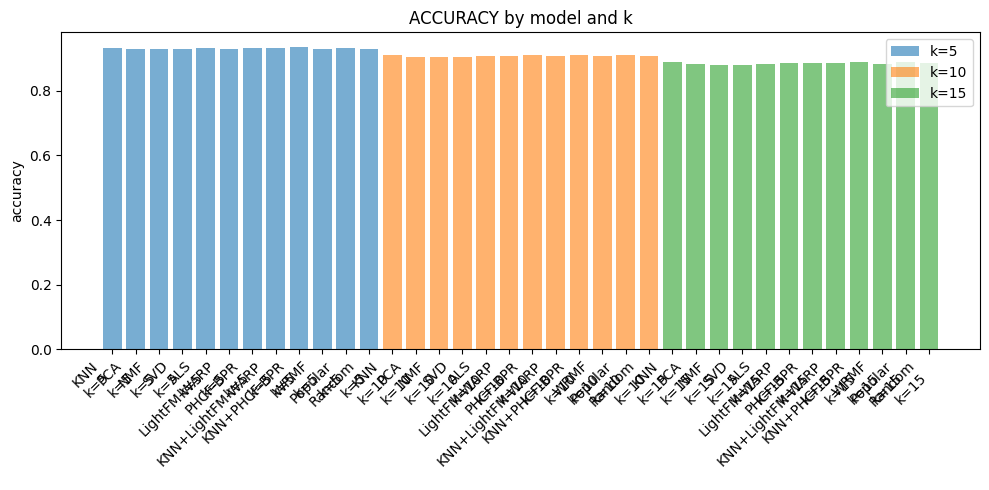

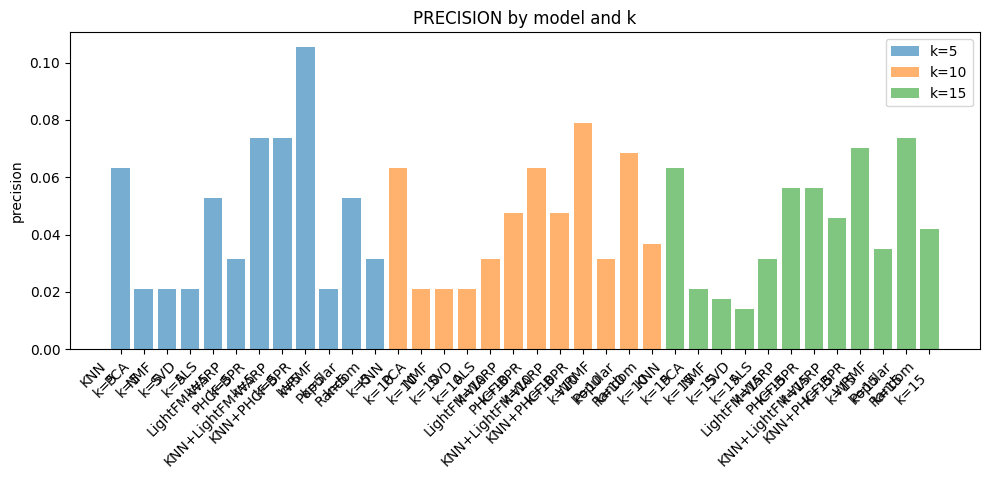

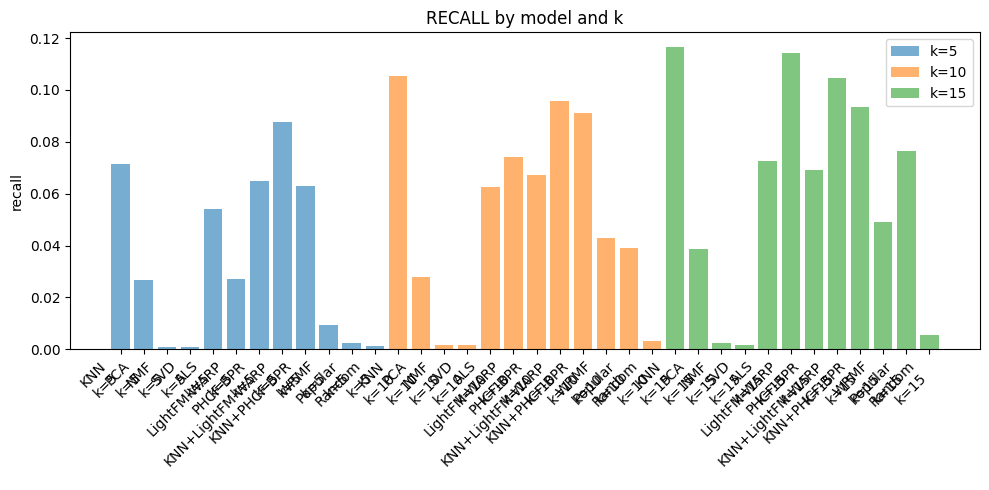

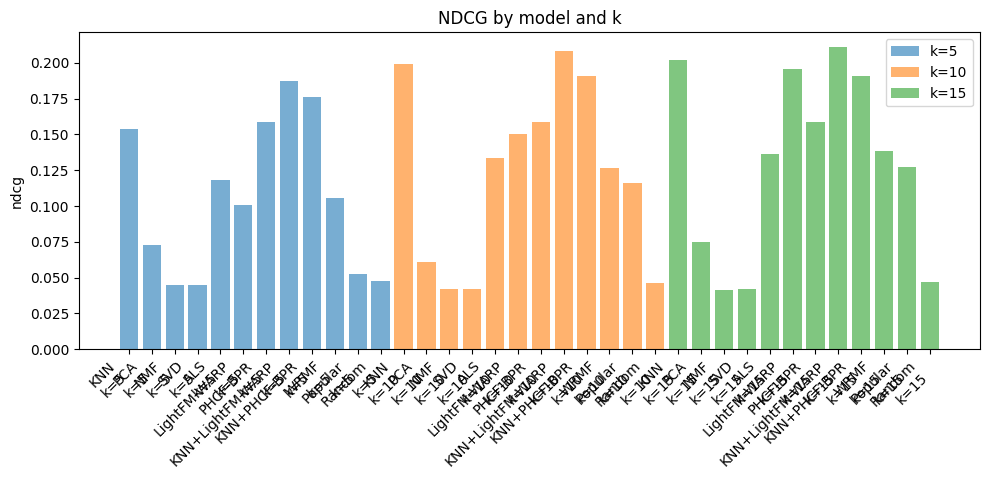

In [3]:
k_values = [5, 10, 15]
results = {model: {k: {} for k in k_values} for model in models.keys()}



for name, model in models.items():
    print(f"\n=== {name} ===")
    if name == 'LightFM-WARP' or name == 'PHCF-BPR':
        model.fit(df_train, owners, mids)
        preds = model.predict()
    elif name == 'KNN+LightFM-WARP' or name == 'KNN+PHCF-BPR':
        model.fit(df_train, owners, mids, X_train)
        preds = model.predict()
    else:
        model.fit(X_train)
        preds = model.predict()

    for k in k_values:
        recs = get_recommendations(preds, used_train, popular_services, k)
        metrics = evaluate(recs, actual_test, mids, preds, k)
        results[name][k] = metrics
        print(f"\nk={k}:")
        for m, v in metrics.items():
            print(f"{m.capitalize()}: {v:.4f}")

# Визуализация
for metric in ['accuracy', 'precision', 'recall', 'ndcg']:
    plt.figure(figsize=(10, 5))
    for k in k_values:
        values = [results[model][k][metric] for model in models]
        plt.bar([f"{model}\nk={k}" for model in models], values, alpha=0.6, label=f"k={k}")
    plt.title(f"{metric.upper()} by model and k")
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [4]:
# Сводная таблица средних метрик по модели
print("===== Average Metrics per Model =====")
avg_summary = {}
for model in models:
    avg = {metric: np.mean([results[model][k][metric] for k in k_values]) for metric in ['accuracy', 'precision', 'recall', 'ndcg']}
    avg_summary[model] = avg
    print(f"{model}:")
    for m, v in avg.items():
        print(f"  {m.capitalize()}: {v:.4f}")


===== Average Metrics per Model =====
KNN:
  Accuracy: 0.9106
  Precision: 0.0632
  Recall: 0.0978
  Ndcg: 0.1849
PCA:
  Accuracy: 0.9064
  Precision: 0.0211
  Recall: 0.0310
  Ndcg: 0.0696
NMF:
  Accuracy: 0.9062
  Precision: 0.0199
  Recall: 0.0016
  Ndcg: 0.0428
SVD:
  Accuracy: 0.9060
  Precision: 0.0187
  Recall: 0.0015
  Ndcg: 0.0431
ALS:
  Accuracy: 0.9078
  Precision: 0.0386
  Recall: 0.0631
  Ndcg: 0.1295
LightFM-WARP:
  Accuracy: 0.9092
  Precision: 0.0450
  Recall: 0.0719
  Ndcg: 0.1489
PHCF-BPR:
  Accuracy: 0.9104
  Precision: 0.0643
  Recall: 0.0671
  Ndcg: 0.1586
KNN+LightFM-WARP:
  Accuracy: 0.9094
  Precision: 0.0556
  Recall: 0.0960
  Ndcg: 0.2021
KNN+PHCF-BPR:
  Accuracy: 0.9122
  Precision: 0.0848
  Recall: 0.0824
  Ndcg: 0.1859
WRMF:
  Accuracy: 0.9074
  Precision: 0.0292
  Recall: 0.0338
  Ndcg: 0.1232
Popular:
  Accuracy: 0.9111
  Precision: 0.0649
  Recall: 0.0392
  Ndcg: 0.0986
Random:
  Accuracy: 0.9081
  Precision: 0.0368
  Recall: 0.0033
  Ndcg: 0.0470


In [5]:
# Сводная таблица средних метрик по модели и экспорт всех метрик в Excel
import openpyxl
avg_summary_df = pd.DataFrame(avg_summary).T
avg_summary_df.index.name = 'Model'
writer = pd.ExcelWriter("model_comparison_summary.xlsx", engine="openpyxl")

# Средние метрики
avg_summary_df.index.name = 'Model'
# Добавляем цветовую заливку (heatmap) в Excel
from openpyxl.styles import PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.formatting.rule import ColorScaleRule

avg_summary_df.to_excel(writer, sheet_name="Averages")
ws = writer.sheets["Averages"]

# Добавим цветовую шкалу к метрикам
color_rule = ColorScaleRule(start_type='min', start_color='FFFFFF',
                            mid_type='percentile', mid_value=50, mid_color='FFFF99',
                            end_type='max', end_color='63BE7B')

for col in range(2, 6):  # B to E (метрики)
    col_letter = chr(64 + col)
    ws.conditional_formatting.add(f"{col_letter}2:{col_letter}{1+len(avg_summary_df)}", color_rule)

# Метрики по каждому k
for k in k_values:
    k_df = pd.DataFrame({model: results[model][k] for model in models}).T
    k_df.index.name = 'Model'
    k_df.to_excel(writer, sheet_name=f"k={k}")

writer.close()

In [6]:
!pip install recbole deepctr-torch

import pandas as pd
import numpy as np
import torch
# RecBole imports for NCF and SASRec
from recbole.data import create_dataset, data_preparation
from recbole.config import Config
from recbole.model.general_recommender import NeuMF    # Neural CF model (NeuMF for NCF)
from recbole.model.sequential_recommender import SASRec  # SASRec sequential model
from recbole.trainer import Trainer
# DeepCTR-Torch imports for DeepFM
from deepctr_torch.inputs import SparseFeat, get_feature_names
from deepctr_torch.models import DeepFM

class NCFRecommender:
    """Neural Collaborative Filtering (NCF) recommender using NeuMF model (GMF + MLP)."""
    def __init__(self, embed_dim=32, epochs=10, device=None):
        self.embed_dim = embed_dim
        self.epochs = epochs
        # Use GPU if available, else CPU
        if device:
            self.device = device
        else:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = None
        self.dataset = None
        self.user_train_items = {}

    def fit(self, train_data: pd.DataFrame):
        """
        Train the NCF (NeuMF) model on the given training data.
        train_data should be a DataFrame with columns: user_id, item_id (and optional rating).
        If rating is not provided, it will be assumed as implicit feedback with rating=1 for each interaction.
        """
        # Determine column names for user and item
        user_col = 'user_id' if 'user_id' in train_data.columns else ('user' if 'user' in train_data.columns else 'owner')
        item_col = 'item_id' if 'item_id' in train_data.columns else ('item' if 'item' in train_data.columns else 'mid')
        df = train_data.copy()
        # Rename to standard names for RecBole
        df = df.rename(columns={user_col: 'user_id', item_col: 'item_id'})
        # Add implicit rating if not present
        if 'rating' not in df.columns:
            df['rating'] = 1.0
        # Drop any timestamp or other columns (not needed for NCF)
        load_cols = ['user_id', 'item_id', 'rating']
        df = df[load_cols]
        # Prepare data file for RecBole
        dataset_name = "webrec_data"
        import os
        os.makedirs(f"dataset/{dataset_name}", exist_ok=True)
        data_path = f"dataset/{dataset_name}/{dataset_name}.inter"
        # Save interactions to file (tab-separated)
        df.to_csv(data_path, sep='\t', index=False, header=True)
        # Configure RecBole for NeuMF model
        config_dict = {
            'USER_ID_FIELD': 'user_id',
            'ITEM_ID_FIELD': 'item_id',
            'RATING_FIELD': 'rating',
            'load_col': {'inter': ['user_id', 'item_id', 'rating']},
            'latent_dim': self.embed_dim,        # embedding size for GMF and MLP parts
            'epochs': self.epochs,
            'device': self.device,
            'neg_sampling': {'uniform': 1},     # sample 1 negative for each positive (implicit feedback)
            'eval_args': {'split': {'RS':[1,0,0]}},  # use all data for training (no internal split)
            'train_batch_size': 256,
            'eval_batch_size': 256
        }
        config = Config(model='NeuMF', dataset=dataset_name, config_dict=config_dict)
        # Create dataset and train data loader
        self.dataset = create_dataset(config)
        train_data, valid_data, test_data = data_preparation(config, self.dataset)
        # Initialize and train NeuMF model
        self.model = NeuMF(config, self.dataset).to(self.device)
        trainer = Trainer(config, self.model)
        trainer.fit(train_data, valid_data=None)  # train for specified epochs
        # Store training items per user for exclusion during prediction
        grouped = df.groupby('user_id')['item_id'].apply(list)
        self.user_train_items = {user: set(items) for user, items in zip(grouped.index, grouped.values)}

    def predict(self, users, k=10):
        """
        Predict top-k item recommendations for given user(s).
        If a single user ID is provided, returns a list of top-k recommended item IDs.
        If a list of users is provided, returns a dict {user: [recommended items]}.
        """
        if self.model is None:
            raise Exception("Model not trained. Call fit() first.")
        # Ensure users is a list
        if not isinstance(users, (list, tuple, np.ndarray, pd.Series)):
            user_list = [users]
        else:
            user_list = list(users)
        self.model.eval()
        recommendations = {}
        # Get total number of items in the model (for scoring all candidates)
        n_items = self.dataset.item_num  # number of items in training data
        for user in user_list:
            if user not in self.user_train_items:
                # If user not seen in training, return empty list
                recommendations[user] = []
                continue
            # Get internal user id
            if user in self.dataset.token2id['user_id']:
                user_idx = self.dataset.token2id['user_id'][user]
            else:
                recommendations[user] = []
                continue
            # Prepare input of all candidate items for this user
            # (We will score all items and then filter out those seen in training)
            # Determine internal item indices range (handle whether indexing starts at 0 or 1)
            if 0 in self.dataset.id2token['item_id']:
                item_indices = np.arange(n_items)  # if items indexed from 0
            else:
                item_indices = np.arange(1, n_items+1)  # if items indexed from 1
            # Create interaction object for RecBole model
            from recbole.utils import Interaction
            input_inter = Interaction({
                'user_id': torch.tensor([user_idx] * len(item_indices), dtype=torch.long, device=self.device),
                'item_id': torch.tensor(item_indices, dtype=torch.long, device=self.device)
            })
            with torch.no_grad():
                scores = self.model.predict(input_inter).view(-1).cpu().numpy()
            # Exclude items the user already interacted with in training
            for seen_item in self.user_train_items.get(user, []):
                if seen_item in self.dataset.token2id['item_id']:
                    seen_idx = self.dataset.token2id['item_id'][seen_item]
                    if 0 <= seen_idx < len(scores):
                        scores[seen_idx] = -np.inf
            # Get top-k item indices
            topk_idx = np.argpartition(scores, -k)[-k:]
            topk_idx = topk_idx[np.argsort(-scores[topk_idx])]  # sort them by score descending
            # Map internal ids back to original item IDs
            topk_items = [self.dataset.id2token['item_id'][int(i)] for i in topk_idx]
            recommendations[user] = topk_items
        # If a single user was given, return list instead of dict for convenience
        if len(user_list) == 1:
            return recommendations[user_list[0]]
        return recommendations

class DeepFMRecommender:
    """Deep Factorization Machine (DeepFM) recommender for implicit feedback."""
    def __init__(self, embed_dim=8, epochs=10, device=None):
        self.embed_dim = embed_dim
        self.epochs = epochs
        if device:
            self.device = device
        else:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = None
        self.user2idx = {}
        self.item2idx = {}
        self.user_train_items = {}
        self.all_items = set()

    def fit(self, train_data: pd.DataFrame):
        """
        Train the DeepFM model on the given training data.
        Expects train_data with columns: user_id, item_id (and optional rating).
        Uses binary labels (1 for interaction, 0 for no interaction) with negative sampling.
        """
        # Determine user/item column names
        user_col = 'user_id' if 'user_id' in train_data.columns else ('user' if 'user' in train_data.columns else 'owner')
        item_col = 'item_id' if 'item_id' in train_data.columns else ('item' if 'item' in train_data.columns else 'mid')
        df = train_data.copy()
        # Rename to standard names
        df = df.rename(columns={user_col: 'user_id', item_col: 'item_id'})
        # Create user and item index mappings
        users = df['user_id'].unique().tolist()
        items = df['item_id'].unique().tolist()
        self.user2idx = {u: i for i, u in enumerate(users)}
        self.item2idx = {it: j for j, it in enumerate(items)}
        # Store user -> seen items (set) for exclusion later
        grouped = df.groupby('user_id')['item_id'].apply(list)
        self.user_train_items = {user: set(items) for user, items in zip(grouped.index, grouped.values)}
        self.all_items = set(items)
        # Prepare training instances with negative sampling
        user_list = []
        item_list = []
        label_list = []
        np.random.seed(42)
        for u, i in zip(df['user_id'], df['item_id']):
            # positive instance
            user_list.append(self.user2idx[u])
            item_list.append(self.item2idx[i])
            label_list.append(1)
            # sample one negative item for this user
            neg_item = np.random.choice(list(self.all_items - self.user_train_items[u]))
            user_list.append(self.user2idx[u])
            item_list.append(self.item2idx[neg_item])
            label_list.append(0)
        user_list = np.array(user_list)
        item_list = np.array(item_list)
        labels = np.array(label_list)
        # Define feature columns for DeepFM (two sparse features: user_id and item_id)
        num_users = len(self.user2idx)
        num_items = len(self.item2idx)
        linear_feat_cols = [SparseFeat('user_id', vocabulary_size=num_users, embedding_dim=self.embed_dim),
                            SparseFeat('item_id', vocabulary_size=num_items, embedding_dim=self.embed_dim)]
        dnn_feat_cols = linear_feat_cols  # in DeepFM, use same features for deep part
        feature_names = get_feature_names(linear_feat_cols + dnn_feat_cols)
        # Prepare model input as dictionary
        train_model_input = {
            'user_id': user_list,
            'item_id': item_list
        }
        # Initialize DeepFM model (classification task for implicit feedback)
        self.model = DeepFM(linear_feat_cols, dnn_feat_cols, task='binary', device=self.device)
        self.model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
        # Train the model
        self.model.fit(train_model_input, labels, batch_size=256, epochs=self.epochs, verbose=2)

    def predict(self, users, k=10):
        """
        Recommend top-k items for given user(s) based on the trained DeepFM model.
        Returns a list of item IDs for a single user or a dict of {user: [item_ids]} for multiple users.
        """
        if self.model is None:
            raise Exception("Model not trained. Call fit() first.")
        # Ensure users is a list
        if not isinstance(users, (list, tuple, np.ndarray, pd.Series)):
            user_list = [users]
        else:
            user_list = list(users)
        recommendations = {}
        for user in user_list:
            if user not in self.user_train_items:
                recommendations[user] = []
                continue
            u_idx = self.user2idx.get(user)
            if u_idx is None:
                recommendations[user] = []
                continue
            # Prepare candidate items (exclude items seen in training)
            candidate_items = np.array(list(self.all_items - self.user_train_items.get(user, set())))
            if len(candidate_items) == 0:
                recommendations[user] = []
                continue
            u_idx_array = np.array([u_idx] * len(candidate_items))
            # Prepare model input for all candidate items of this user
            model_input = {"user_id": u_idx_array, "item_id": np.array([self.item2idx[it] for it in candidate_items])}
            # Get prediction scores for all candidates
            scores = self.model.predict(model_input, batch_size=256)
            scores = scores.reshape(-1)
            # Select top-k highest scores
            if len(scores) < k:
                topk_indices = np.argsort(-scores)  # if fewer candidates than k
            else:
                topk_indices = np.argpartition(-scores, k-1)[:k]
                topk_indices = topk_indices[np.argsort(-scores[topk_indices])]
            topk_items = candidate_items[topk_indices]
            recommendations[user] = topk_items.tolist()
        # Return list for single user input
        if len(user_list) == 1:
            return recommendations[user_list[0]]
        return recommendations

class SASRecRecommender:
    """Sequential recommender using SASRec (Self-Attentive Sequential Recommendation)."""
    def __init__(self, max_seq_len=50, epochs=10, device=None):
        self.max_seq_len = max_seq_len
        self.epochs = epochs
        if device:
            self.device = device
        else:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = None
        self.dataset = None
        self.user_train_items = {}
        self.user_sequences = {}

    def fit(self, train_data: pd.DataFrame):
        """
        Train SASRec sequential model on the given training data.
        train_data should contain user_id, item_id, and a timestamp or time ordering of interactions.
        """
        # Determine user/item column names and ensure timestamp is present
        user_col = 'user_id' if 'user_id' in train_data.columns else ('user' if 'user' in train_data.columns else 'owner')
        item_col = 'item_id' if 'item_id' in train_data.columns else ('item' if 'item' in train_data.columns else 'mid')
        time_col = 'timestamp' if 'timestamp' in train_data.columns else ('time' if 'time' in train_data.columns else 'start_time')
        df = train_data.copy()
        df = df.rename(columns={user_col: 'user_id', item_col: 'item_id', time_col: 'start_time'})
        # Convert start_time to numeric timestamp if not already numeric
        if df['start_time'].dtype == object or df['start_time'].dtype == 'datetime64[ns]':
            df['timestamp'] = pd.to_datetime(df['start_time']).astype('int64') // 10**9
        else:
            # If already numeric timestamp
            df['timestamp'] = df['start_time'].astype(int)
        # Sort interactions by user and time
        df = df.sort_values(['user_id', 'timestamp'])
        # Add implicit rating column (all ones) for consistency
        df['rating'] = 1.0
        # Keep only necessary columns
        df = df[['user_id', 'item_id', 'timestamp', 'rating']]
        # Prepare data file for RecBole
        dataset_name = "webrec_seq"
        import os
        os.makedirs(f"dataset/{dataset_name}", exist_ok=True)
        data_path = f"dataset/{dataset_name}/{dataset_name}.inter"
        df.to_csv(data_path, sep='\t', index=False, header=True)
        # Configure RecBole for SASRec model
        config_dict = {
            'USER_ID_FIELD': 'user_id',
            'ITEM_ID_FIELD': 'item_id',
            'TIME_FIELD': 'timestamp',
            'RATING_FIELD': 'rating',
            'load_col': {'inter': ['user_id', 'item_id', 'timestamp', 'rating']},
            'MODEL_TYPE': 'Sequential',
            'ITEM_LIST_LENGTH_FIELD': 'item_length',
            'LIST_SUFFIX': '_list',
            'MAX_ITEM_LIST_LENGTH': self.max_seq_len,
            'epochs': self.epochs,
            'device': self.device,
            'neg_sampling': {'uniform': 1},
            'eval_args': {'split': {'RS':[1,0,0]}},
            'train_batch_size': 256,
            'eval_batch_size': 256
        }
        config = Config(model='SASRec', dataset=dataset_name, config_dict=config_dict)
        self.dataset = create_dataset(config)
        train_data, valid_data, test_data = data_preparation(config, self.dataset)
        # Initialize and train SASRec model
        self.model = SASRec(config, self.dataset).to(self.device)
        trainer = Trainer(config, self.model)
        trainer.fit(train_data, valid_data=None)
        # Store user -> seen items and sequences for later predictions
        grouped_items = df.groupby('user_id')['item_id'].apply(list)
        self.user_train_items = {user: set(items) for user, items in zip(grouped_items.index, grouped_items.values)}
        self.user_sequences = {user: items for user, items in zip(grouped_items.index, grouped_items.values)}

    def predict(self, users, k=10):
        """
        Recommend top-k next items for given user(s) based on their sequence of past interactions.
        Returns a list of item IDs for a single user or a dict of {user: [item_ids]} for multiple users.
        """
        if self.model is None:
            raise Exception("Model not trained. Call fit() first.")
        if not isinstance(users, (list, tuple, np.ndarray, pd.Series)):
            user_list = [users]
        else:
            user_list = list(users)
        self.model.eval()
        recommendations = {}
        for user in user_list:
            if user not in self.user_sequences:
                recommendations[user] = []
                continue
            # Get internal user id if needed (SASRec model uses sequence, user_id not directly used in scoring)
            user_seq = self.user_sequences[user]
            # Convert item IDs in the sequence to internal indices
            seq_idx = []
            for it in user_seq:
                if it in self.dataset.token2id['item_id']:
                    seq_idx.append(self.dataset.token2id['item_id'][it])
            # Truncate/pad sequence to max_seq_len
            L = self.max_seq_len
            if len(seq_idx) > L:
                seq_idx = seq_idx[-L:]
            seq_len = len(seq_idx)
            if seq_len < L:
                # pad with 0 (padding index for item embedding)
                seq_idx = [0] * (L - seq_len) + seq_idx
            seq_idx = np.array(seq_idx, dtype=int)
            # Prepare interaction for one user sequence
            from recbole.utils import Interaction
            input_inter = Interaction({
                'item_id_list': torch.tensor([seq_idx], dtype=torch.long, device=self.device),
                'item_length': torch.tensor([seq_len], dtype=torch.long, device=self.device)
            })
            with torch.no_grad():
                scores = self.model.full_sort_predict(input_inter).view(-1).cpu().numpy()
            # Set scores of padded item (index 0) and seen items to -inf to exclude them
            if 0 < len(scores):
                scores[0] = -np.inf
            for seen_item in self.user_train_items.get(user, []):
                if seen_item in self.dataset.token2id['item_id']:
                    seen_idx = self.dataset.token2id['item_id'][seen_item]
                    if 0 <= seen_idx < len(scores):
                        scores[seen_idx] = -np.inf
            # Get top-k indices
            if len(scores) == 0:
                recommendations[user] = []
                continue
            topk_idx = np.argpartition(scores, -k)[-k:]
            topk_idx = topk_idx[np.argsort(-scores[topk_idx])]
            topk_items = [self.dataset.id2token['item_id'][int(i)] for i in topk_idx]
            recommendations[user] = topk_items
        if len(user_list) == 1:
            return recommendations[user_list[0]]
        return recommendations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1

In [11]:
used_train = get_used_services(X_train)
actual_test = get_used_services(X_test)


models = {
    'KNN': KNNRecommender(),
    'PCA': SVDRecommender(PCA(n_components=5)),
    'NMF': SVDRecommender(NMF(n_components=5, init='random', random_state=0)),
    'SVD': SVDRecommender(TruncatedSVD(n_components=5)),'ALS': best_als(X_train, X_test, used_train, actual_test, mids, popular_services, k=15),
    'ALS': best_als(X_train, X_test, used_train, actual_test, mids, popular_services, k=15),
    'LightFM-WARP': best_lightFM(df_train, owners, mids, X_train, used_train, actual_test,  popular_services, k=15, loss='warp'),
    'PHCF-BPR': best_lightFM(df_train, owners, mids, X_train, used_train, actual_test,  popular_services, k=15, loss='bpr'),
    'KNN+LightFM-WARP': best_knn_lightFM(df_train, owners, mids, X_train, used_train, actual_test,  popular_services, k=15, loss='warp'),
    'KNN+PHCF-BPR': best_knn_lightFM(df_train, owners, mids, X_train, used_train, actual_test,  popular_services, k=15, loss='bpr'),
    'WRMF': WRMFRecommender(),
    'NCF': NCFRecommender(),
    'DeepFM': DeepFMRecommender(),
    'SASRec': SASRecRecommender(),
    'Popular': PopularRecommender(popular_services),
    'Random': RandomRecommender(),
}

k_values = [5, 10, 15]
results = {model: {k: {} for k in k_values} for model in models.keys()}

for name, model in models.items():
    print(f"\n=== {name} ===")
    if name in ['LightFM-WARP', 'PHCF-BPR', 'NCF', 'DeepFM', 'SASRec']:
        model.fit(df_train, owners, mids)
    elif name == 'KNN+LightFM-WARP' or name == 'KNN+PHCF-BPR':
        model.fit(df_train, owners, mids, X_train)
    else:
        model.fit(X_train)

    preds = model.predict()
    for k in k_values:
        recs = get_recommendations(preds, used_train, popular_services, k)
        metrics = evaluate(recs, actual_test, mids, preds, k)
        results[name][k] = metrics
        print(f"\nk={k}:")
        for m, v in metrics.items():
            print(f"{m.capitalize()}: {v:.4f}")


  0%|          | 0/10 [00:00<?, ?it/s]

factors=10, reg=0.01, iters=10 -> {'accuracy': np.float64(0.8817773075905846), 'precision': np.float64(0.017543859649122806), 'recall': np.float64(0.023769359295675082), 'ndcg': np.float64(0.07643737627842499)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=10, reg=0.01, iters=20 -> {'accuracy': np.float64(0.8854800317376356), 'precision': np.float64(0.042105263157894736), 'recall': np.float64(0.042309298888246256), 'ndcg': np.float64(0.10664324258654471)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=10, reg=0.1, iters=10 -> {'accuracy': np.float64(0.8849510711451997), 'precision': np.float64(0.03859649122807018), 'recall': np.float64(0.06772540325171904), 'ndcg': np.float64(0.09927874510116376)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=10, reg=0.1, iters=20 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.03157894736842106), 'recall': np.float64(0.06069661332819227), 'ndcg': np.float64(0.08366237281861912)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=10, reg=1, iters=10 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.0724246513720198), 'ndcg': np.float64(0.1556544098361019)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=10, reg=1, iters=20 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.0724246513720198), 'ndcg': np.float64(0.13651713338041388)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=20, reg=0.01, iters=10 -> {'accuracy': np.float64(0.8817773075905846), 'precision': np.float64(0.017543859649122806), 'recall': np.float64(0.024709208919735236), 'ndcg': np.float64(0.07690250907244352)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=20, reg=0.01, iters=20 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06946854315275368), 'ndcg': np.float64(0.08408643549396776)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=20, reg=0.1, iters=10 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.03157894736842106), 'recall': np.float64(0.05451639004270584), 'ndcg': np.float64(0.11338803743922127)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=20, reg=0.1, iters=20 -> {'accuracy': np.float64(0.8844221105527638), 'precision': np.float64(0.03508771929824561), 'recall': np.float64(0.0786903155324208), 'ndcg': np.float64(0.13681929332550197)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=20, reg=1, iters=10 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06365272154745838), 'ndcg': np.float64(0.1528080031081144)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=20, reg=1, iters=20 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06365272154745838), 'ndcg': np.float64(0.13377751900220408)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=40, reg=0.01, iters=10 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.039165512849723375), 'ndcg': np.float64(0.08754254974341862)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=40, reg=0.01, iters=20 -> {'accuracy': np.float64(0.8854800317376356), 'precision': np.float64(0.042105263157894736), 'recall': np.float64(0.07684493868704395), 'ndcg': np.float64(0.17691462533137522)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=40, reg=0.1, iters=10 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.04360259623417518), 'ndcg': np.float64(0.07571360188915252)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=40, reg=0.1, iters=20 -> {'accuracy': np.float64(0.8844221105527638), 'precision': np.float64(0.03508771929824562), 'recall': np.float64(0.08701240280187648), 'ndcg': np.float64(0.14137089383784357)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=40, reg=1, iters=10 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06365272154745838), 'ndcg': np.float64(0.1335639343026486)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=40, reg=1, iters=20 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06365272154745838), 'ndcg': np.float64(0.13338325329608583)}

Best ALS params: {'factors': 10.0, 'regularization': 0.01, 'iterations': 20.0}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=10, reg=0.01, iters=10 -> {'accuracy': np.float64(0.8823062681830204), 'precision': np.float64(0.021052631578947368), 'recall': np.float64(0.02641218430692115), 'ndcg': np.float64(0.06944768425876241)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=10, reg=0.01, iters=20 -> {'accuracy': np.float64(0.8828352287754563), 'precision': np.float64(0.02456140350877193), 'recall': np.float64(0.020681803576540415), 'ndcg': np.float64(0.08499627723535767)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=10, reg=0.1, iters=10 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.05670937249884618), 'ndcg': np.float64(0.10912174348215369)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=10, reg=0.1, iters=20 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596495), 'recall': np.float64(0.06024677077308656), 'ndcg': np.float64(0.08340418567572448)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=10, reg=1, iters=10 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.0724246513720198), 'ndcg': np.float64(0.13622966002407336)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=10, reg=1, iters=20 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.0724246513720198), 'ndcg': np.float64(0.1364103410306361)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=20, reg=0.01, iters=10 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.026058736585052377), 'ndcg': np.float64(0.07372332366454212)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=20, reg=0.01, iters=20 -> {'accuracy': np.float64(0.8849510711451997), 'precision': np.float64(0.03859649122807017), 'recall': np.float64(0.06194390404916721), 'ndcg': np.float64(0.10736367452134284)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=20, reg=0.1, iters=10 -> {'accuracy': np.float64(0.8823062681830204), 'precision': np.float64(0.021052631578947368), 'recall': np.float64(0.016836964205385257), 'ndcg': np.float64(0.06020529885219123)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=20, reg=0.1, iters=20 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.07824047297731508), 'ndcg': np.float64(0.126941864614585)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=20, reg=1, iters=10 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06365272154745838), 'ndcg': np.float64(0.1528080031081144)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=20, reg=1, iters=20 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06365272154745838), 'ndcg': np.float64(0.1335639343026486)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=40, reg=0.01, iters=10 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.03084342558026769), 'ndcg': np.float64(0.11833656531379394)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=40, reg=0.01, iters=20 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.05670937249884618), 'ndcg': np.float64(0.11207087600652582)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=40, reg=0.1, iters=10 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.04360259623417518), 'ndcg': np.float64(0.07938162167558312)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=40, reg=0.1, iters=20 -> {'accuracy': np.float64(0.883893149960328), 'precision': np.float64(0.031578947368421054), 'recall': np.float64(0.07824047297731508), 'ndcg': np.float64(0.13978619190647193)}


  0%|          | 0/10 [00:00<?, ?it/s]

factors=40, reg=1, iters=10 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06365272154745838), 'ndcg': np.float64(0.1335639343026486)}


  0%|          | 0/20 [00:00<?, ?it/s]

factors=40, reg=1, iters=20 -> {'accuracy': np.float64(0.8833641893678921), 'precision': np.float64(0.028070175438596492), 'recall': np.float64(0.06365272154745838), 'ndcg': np.float64(0.13338325329608583)}

Best ALS params: {'factors': 20.0, 'regularization': 0.01, 'iterations': 20.0}
loss=warp, epochs=10, no_components=10 -> {'accuracy': np.float64(0.8854800317376356), 'precision': np.float64(0.042105263157894736), 'recall': np.float64(0.09705995758627337), 'ndcg': np.float64(0.1482555137984552)}
loss=warp, epochs=10, no_components=20 -> {'accuracy': np.float64(0.887066913514943), 'precision': np.float64(0.05263157894736842), 'recall': np.float64(0.11380052695842169), 'ndcg': np.float64(0.18681499460469642)}
loss=warp, epochs=10, no_components=40 -> {'accuracy': np.float64(0.887595874107379), 'precision': np.float64(0.056140350877192984), 'recall': np.float64(0.1142503695135274), 'ndcg': np.float64(0.2575587785984389)}
loss=warp, epochs=20, no_components=10 -> {'accuracy': np.float64

  0%|          | 0/20 [00:00<?, ?it/s]


k=5:
Accuracy: 0.9310
Precision: 0.0316
Recall: 0.0155
Ndcg: 0.0532

k=10:
Accuracy: 0.9069
Precision: 0.0263
Recall: 0.0164
Ndcg: 0.0573

k=15:
Accuracy: 0.8834
Precision: 0.0281
Recall: 0.0177
Ndcg: 0.0611

=== LightFM-WARP ===

k=5:
Accuracy: 0.9320
Precision: 0.0526
Recall: 0.0540
Ndcg: 0.1022

k=10:
Accuracy: 0.9106
Precision: 0.0632
Recall: 0.0826
Ndcg: 0.1545

k=15:
Accuracy: 0.8876
Precision: 0.0561
Recall: 0.0927
Ndcg: 0.1582

=== PHCF-BPR ===

k=5:
Accuracy: 0.9331
Precision: 0.0737
Recall: 0.0650
Ndcg: 0.1602

k=10:
Accuracy: 0.9101
Precision: 0.0579
Recall: 0.0668
Ndcg: 0.1594

k=15:
Accuracy: 0.8876
Precision: 0.0561
Recall: 0.0761
Ndcg: 0.1729

=== KNN+LightFM-WARP ===

k=5:
Accuracy: 0.9320
Precision: 0.0526
Recall: 0.0641
Ndcg: 0.1395

k=10:
Accuracy: 0.9085
Precision: 0.0421
Recall: 0.0826
Ndcg: 0.1452

k=15:
Accuracy: 0.8871
Precision: 0.0526
Recall: 0.1195
Ndcg: 0.1612

=== KNN+PHCF-BPR ===

k=5:
Accuracy: 0.9326
Precision: 0.0632
Recall: 0.0286
Ndcg: 0.0858

k=10:


  0%|          | 0/10 [00:00<?, ?it/s]


k=5:
Accuracy: 0.9304
Precision: 0.0211
Recall: 0.0092
Ndcg: 0.0526

k=10:
Accuracy: 0.9074
Precision: 0.0316
Recall: 0.0252
Ndcg: 0.0740

k=15:
Accuracy: 0.8834
Precision: 0.0281
Recall: 0.0261
Ndcg: 0.0758

=== NCF ===


TypeError: NCFRecommender.fit() takes 2 positional arguments but 4 were given